 # An applied introduction to Generative Adversarial Nets 

As of late there is an immense interest in Artificial Intelligence research and especially in the field of deep learning. Deep learning is the branch of machine learning that its algorithms are formed by stacking layers of neural networks. Neural networks are function approximators that introduce non linearities on the input through activation neurons. In this point I will assume that the reader has at least a basic data science and machine learning background.

In this post we are going to talk about Generative Adversarial Nets (GANs), an algorithm that was first introduced in 2014 from Ian Goodfellow at Universite de Montreal under Joshua Bengio. GANs are of particular interest to me because they marry two fields that I love: deep learning and game theory. The algorithm is set up as a two player game where one agent acts as a counterfeiter and the other as a police man. Competition in this game drives both agents to improve their methods of counterfeiting and distinguishing fake data.  

##  Discriminative vs Generative tasks

Before we go into the ins and outs of GANs we should be clear on what we are trying to achieve when we are using a generative model. Most of the successful A.I. algorithms are trying in some way to classify an input to an output space. For example, the most well known problem in A.I. is the image classification problem and its toy/benchmark dataset MNIST of handwritten digits. The problem is to classify each handwritten digits to the correct class from 0 to 9. This is a prime example of a discriminative task. In discrimination we have inputs and we want to assign a label to each one of them without caring too much about what kind of confidence we have on the labeling.

On the other hand generative models care a lot about the probabilistic distribution of the output. Generally the model draws samples from a distribution *p<sub>data</sub>* and learns to represent an estimate of that distribution. The resulting probability distribution would be *p<sub>model</sub>*. There are algorithms that compute that probability distribution explicitly, others can generate samples from  *p<sub>model</sub>* and there are models that can do both. Also there are distributions that we could tractably compute and there are others that we have no way of computing as of now. Ian Goodfellow on his tutorial in GANs gives a picture of how the generative field of models look like:

![Classes of generative models. Image taken from Ian Goodfellow's tutorial](images/gen_models.png)

After this brief introduction someone could argue, why do we need generative models when we could have very accurate discriminative models in deep learning? Ian Goodfellow gives a lot of motivation points to pursue further research in generative models in his [NIPS tutorial](https://arxiv.org/pdf/1701.00160.pdf) which I urge you to read. Some of the points that he mentions:

* The ability to represent and manipulate high dimensional distributions through training and sampling are important objects in a variety of fields 
* Sampling from complex distributions can help in enriching datasets and helping in reinforcement learning
* Multi modal outputs - as one to many functions -  can be predicted with generative models

##  How GANs work 

![How GANs work](images/gan_how.png)

We mentioned that GANs marry the notions of game theory and machine learning. GANS have two distinct neural networks that play an adversarial game with each other in order to improve their results. One agent is called the **generator**. The generator is trying to produce samples that are identical to the data that we have at hand. The other agent is the **discriminator**. The discriminator is trying to identify if the data that he receives as inputs are drawn from the data distribution *p<sub>data</sub>* or they come from the generator's distribution *p<sub>g</sub>*. During training generator is trying to produce data points that look exactly as the training data and the discriminator is trying distinguish between data inputs and generator outputs while updating their respective weights and biases.

Assume that we have a dataset that has R^n dimensions. The generator wants to produce output almost identical to the input dataset so its output should be in R^n dimensions. Generator receives as input a "noise" signal *z* which is a known distribution to us. Common distributions are the normal, uniform and linearly spread with a gaussian noise added on top. The reasoning is that as we sample from a known distribution the generator will use that sample to draw a sample from the data distribution. Most of the times there is an assumption that the data reside in a lower dimensional space so we could limit the generator input to live in R^k where k < n. The discriminator is a very familiar beast. Discriminator receives data inputs in R^n and produces a binary label, 1 if the data point belongs to the original data set and 0 if the data point belongs to a generator output. 

The architecture of the generator and the discriminator varies with the task at hand. In the setting that we are going to explore later they are both feed forward neural networks. In an image creation and prediction setting the generator would be a neural net with deconvolution layers and the discriminator would be a stack of convolution layers with a sigmoid out layer. A famous implementation and very robust solution is [DCGAN](https://github.com/carpedm20/DCGAN-tensorflow). Not only the architecture of the actors do matter but also the capacity of each has a tremendous impact on the quality of the results. Again we have to think that generator and discriminator are playing a game and if one player has so much more capacity it could overpower the other and lead to undesirable results. There is some research about balancing discriminator and generator capacity and training time but in practice the discriminator is nice to have some excess capacity.

What makes GANs unique is how the costs of the networks are defined. Let's assume that $\theta^g$ and $\theta^d$ are the parameters of the generator and discriminator respectively and define a cost function $J(\theta^g, \theta^d)$. The generator draws samples from a $p(z)$ and produces an output $G(z;\theta^g)$ where $G$ is the function approximator neural net. The discriminator processes both data $x$ and generator output $G(z;\theta^g)$ that can be defined respectively as $D(x;\theta^d)$ and $D(G(z;\theta^g);\theta^d)$ with $D$ being the function approximator. In other words $D(x;\theta^d)$ is the probability that a data point is drawn from the original distribution and $D(G(z;\theta^g);\theta^d)$ is the probability that a data point belongs to the generator. The discriminator wants to simultaneously maximize $log(D(x;\theta^d)$ and $log(1-D(G(z;\theta^g);\theta^d))$. On the other hand the generator wants to minimize $log(1-D(G(z;\theta^g);\theta^d))$ - the number of correctly classified generator outputs. This leads to a 2 player minmax game that can be stated as;


$J(\theta^g, \theta^d) = min_\theta^g max_\theta^d (E_{x-p(x)}[log(D(x;\theta^d)] + E_{z-p(z)}[log(1-D(G(z;\theta^g);\theta^d))])$ 

Now you can imagine a repetitive game where each player takes turns optimizing their payoff. It is proven that the game converges to an optimal solution and Nash Equilibrium in the function space. And this is a very important observation that there are no guarantees that a GAN will converge in the parameter space. This is the reason why the architecture and capacity of the two actors matter so much. Also this is the reason why GANs are infamous for their difficulty to train.

##  Training of a GAN 

Up untill now we scratched the surface of GANs and gave some intuition to why they matter. At this point you might realize that there are tons of better blog posts and tutorials that explain GANs, why the hell should you read another line? As stated in the beginning of the post I assume that you are familiar with machine learning techniques and if you seek a more in depth take on GANs you should read the corresponding papers. The main purpose of this post is to enable you to use GANs by yourself. We just mentioned that GANs are a pain to train. Through the code and the example below I will demonstrate in Tensorflow how you could train a simple GAN with extensions to more complicated applications. The core components of the code are designed with flexibility in mind, so you can copy them directly and try different network architectures. We will attempt to train our GAN to produce samples from a two dimensional normal distribution that receives as input. Probably this post is the first of a series that I will make in the future so a basic example was required. At some point in the future we will get into the depths of training GANs in different settings.

We will go through each block of the notebook and I will explain what is happening and give some more intuition about the "soft" choices that I had to make. But firstly we need to do our imports. Nothing surprizing.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

%matplotlib inline

We mentioned that we want to train a GAN to produce samples from a two dimensional normal distribution. Then our input data should be drawn from that distribution. We chose the distribution with mean = (5,10) and unit covariance and drawn 1000 samples as it is shown below. 

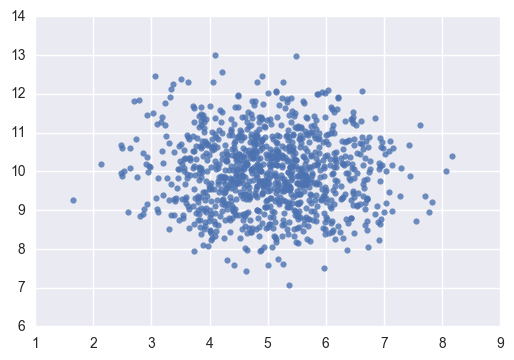

In [3]:
x = np.random.multivariate_normal(mean=[5,10], cov=np.eye(2), size=1000)
sns.regplot(x=x[:,0], y=x[:,1],fit_reg=False)

Below we are defining the input and output dimensions of the generator and the discriminator. Discriminator by default has output dimension 1 and input the dimension of the data, 2. Generator has always output dimension the same as the data dimension and input dimension that is of smaller or equal dimension to the data, depending on how complicated we believe is the underlying manifold.

In [4]:
input_discriminator_dimension = x.shape[1]
input_generator_dimension = 2
discriminator_data = tf.placeholder(tf.float32, [None, input_discriminator_dimension])
generator_input = tf.placeholder(tf.float32, [None, input_generator_dimension])

In this block we define the discriminator actor. It is just a feed forward neural net with a sigmoid output in order to predict 1 for the example taken from the data and 0 for the generated example. For an activation function most people suggest leaky ReLU for GANs. For this toy example it doesn't really affect the quality of the outcome. Also the network is needed to have the capacity to discriminate 2 dimension normal distribution so 2 layers of 100 neurons should be enough.

In [5]:
def discriminator(data, input_dimension, layers, activation, reuse=False):
    with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
        Mi = input_dimension
        weights = {}
        bias = {}
        for layer, i in zip(layers, range(len(layers))):
            Mo = layer
            weights["weight_{}".format(i)] = tf.get_variable("d_w_{}".format(i),
                                                initializer=tf.random_normal(dtype=tf.float32, shape=[Mi, Mo])) 
            bias["bias_{}".format(i)] = tf.get_variable("d_b_{}".format(i), initializer=tf.zeros(Mo))
            Mi = Mo
        weights["out"] = tf.get_variable("d_w_out", 
                                         initializer=tf.random_normal(shape=[Mo, 1], dtype=tf.float32))
        bias["out"] = tf.get_variable("d_b_out", initializer=tf.zeros(1))
        layer_input = data
        for layer in range(len(layers)):
            layer_input = activation(tf.add(tf.matmul(layer_input, weights["weight_{}".format(layer)]), 
                                            bias["bias_{}".format(layer)]))
        logits = tf.add(tf.matmul(layer_input, weights["out"]), bias["out"])
        layer_out = tf.nn.sigmoid(logits)
    return layer_out, logits

Also the generator for our purposes is a regular feed forward neural network with a dense output. The only thing worth noting is that the generator capacity greatly affects the output quality. In our case we chose one layer with 5 neurons! I challenge you to test as many configurations as you can and see the results first hand, only this way you are going to get a feel of how a GAN should be parameterized.

In [6]:
def generator(data, input_dimension, output_dimension, layers, activation, reuse=False):
    with tf.variable_scope("generator") as scope:
        if reuse:
            scope.reuse_variables()
        Mi = input_dimension
        weights = {}
        bias = {}
        for layer, i in zip(layers, range(len(layers))):
            Mo = layer
            weights["weight_{}".format(i)] = tf.get_variable("g_w_{}".format(i), 
                                                initializer=tf.random_normal(dtype=tf.float32, shape=[Mi, Mo]))
            bias["bias_{}".format(i)] = tf.get_variable("g_b_{}".format(i), initializer=tf.zeros(Mo))
            Mi = Mo
        weights["out"] = tf.get_variable("g_w_out", 
                                         initializer=tf.random_normal(shape=[Mo, output_dimension], dtype=tf.float32))
        bias["out"] = tf.get_variable("g_b_out", initializer=tf.zeros(output_dimension))
        layer_input = data
        for layer in range(len(layers)):
            layer_input = activation(tf.add(tf.matmul(layer_input, weights["weight_{}".format(layer)]), 
                                            bias["bias_{}".format(layer)]))
        layer_out = tf.add(tf.matmul(layer_input, weights["out"]), bias["out"])
    return layer_out

In [7]:
z_placeholder = tf.placeholder(tf.float32, [None, input_generator_dimension])
data_placeholder = tf.placeholder(tf.float32, [None, input_discriminator_dimension])

gen = generator(z_placeholder, input_dimension=input_generator_dimension, 
                output_dimension=input_discriminator_dimension, layers=[5], activation=tf.nn.leaky_relu)
dis_data, dis_data_logits = discriminator(data_placeholder, input_dimension=input_discriminator_dimension, 
                                          layers=[100, 100], activation=tf.nn.leaky_relu)
sampler = generator(z_placeholder, input_dimension=input_generator_dimension, 
                    output_dimension=input_discriminator_dimension, layers=[5], 
                    activation=tf.nn.leaky_relu, reuse=True)
dis_sample, dis_sample_logits = discriminator(sampler, input_dimension=input_discriminator_dimension, 
                                              layers=[100, 100], activation=tf.nn.leaky_relu, reuse=True)

Below the costs are being defined. If you notice there is a difference between the cost stated in the min max game in the theoretical section and how it is modeled here. It is stated in Ian Goodfellow's paper that the min max cost does not provide strong enough gradients for the generator to be trained in the early stages of the training process. Intuitively we can understand that when $G$ is producing poor samples the discriminator $D$ will reject them with high confidence and in this case $log(1-G(z))$ saturates. The trick is for the discriminator to minimize and for the generator to maximize $log(G(z))$.  

In [8]:
cost_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_sample_logits, 
                                                                  labels=tf.ones_like(dis_sample)))
cost_dis_data = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_data_logits, 
                                                                       labels=tf.ones_like(dis_data)))
cost_dis_sample = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_sample_logits, 
                                                                         labels=tf.zeros_like(dis_sample)))
cost_dis = cost_dis_data + cost_dis_sample

Also in different parts of the optimization procedure we want to update certain variables and keep others fixed. For example when we train the generator we want the weights and biases of the discriminator to remain constant without gradients flowing through them. Adam optimizer is usually the optimizer of choise for most applications out there and GANs are no exception.

In [9]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]
adam = tf.train.AdamOptimizer(learning_rate=0.1)
dis_opt = adam.minimize(cost_dis, var_list=d_vars)
gen_opt = adam.minimize(cost_gen, var_list=g_vars)

At last we will talk about the actual training of the GAN. The hyperparameters of the training process is the number of epochs, batch size and sample size of the generator output. I will encourage you to try different configurations and see the corresponding results. The ratio of the batch size and sample size will drive more training power to the discriminator or the generator respectively. There is a discussion about what to train more at what point of the training process but practice has proven that keeping those parameters equal usually provides with the best results. Also the number of epochs that we choose is important due to the chance of saturation of the generated output to singular samples that fool the discriminator consistently.

Another choice that has to be made it the form of the distribution that the generator is going to sample from. Popular choices are:
* Uniform sampling from [-1,1]
* Linear sampling from [-range, range] with added gaussian noise
* Gaussian distribution sampling

The sampling distribution puts some form of a prior to the output of the generator. For the purpose of this excersize we chose to sample from a normal distribution.

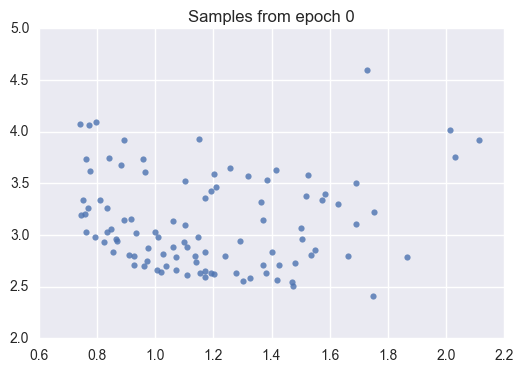

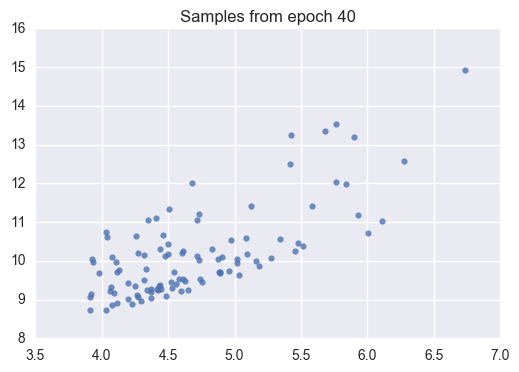

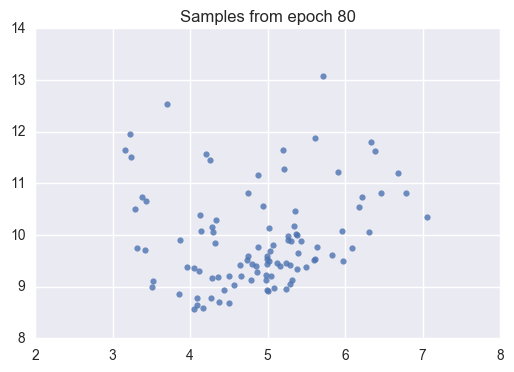

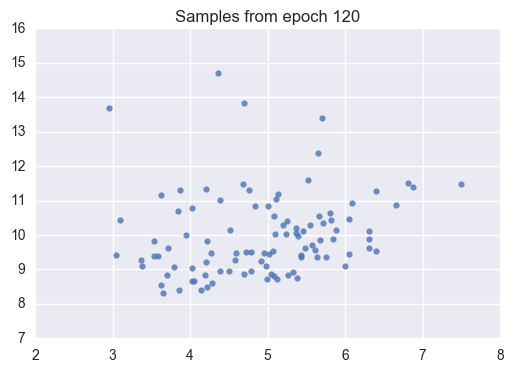

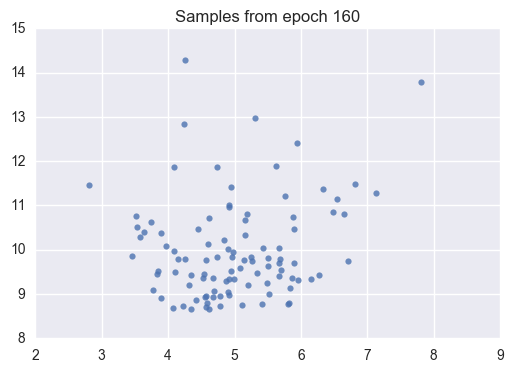

In [25]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())    
g_c = []
d_c = []    
epochs = 200
batch_size = 100
z_sample_size = 100
for e in range(epochs):
    x = shuffle(x)
    for i in range(0, x.shape[0], batch_size):
        z_samples = np.random.normal(0,1, (z_sample_size, input_generator_dimension))
        x_batch = x[i:i+batch_size]
        g_c_b, d_c_b  = sess.run([cost_gen, cost_dis], 
                                 feed_dict={z_placeholder:z_samples, data_placeholder:x_batch})
        _ = sess.run(dis_opt, feed_dict={data_placeholder:x_batch, z_placeholder:z_samples})
        _ = sess.run(gen_opt, feed_dict={z_placeholder:z_samples})
        d_c.append(d_c_b)
        g_c.append(g_c_b)
    if e%40==0:
        sampled_epoch = sess.run(sampler, feed_dict={z_placeholder:z_samples})
        plt.figure()
        plt.title("Samples from epoch {}".format(e))
        sns.regplot(x=sampled_epoch[:,0], y=sampled_epoch[:,1],fit_reg=False)

Finally after training is done we plot 1000 samples from the generator output to verify that the GAN produces sensible results. Pretty cool right??

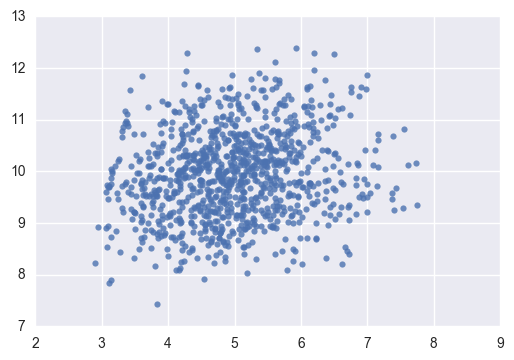

In [24]:
z_test = np.random.normal(0,1, (1000, input_generator_dimension))
sampled_data = sess.run(sampler, feed_dict={z_placeholder:z_test})
sns.regplot(x=sampled_data[:,0], y=sampled_data[:,1],fit_reg=False)

## Summary

In this post we explored the magnificent wolrd of GANs and hopefully I gave you the needed motivation to start experiment yourselves with this algorithm. There are many more models that are based on this basic approach to GANs and we will explore a couple of them in the future! Key take aways from this post:
* GANs are awesome
* Sampling from complex distributions ain't easy
* Since theoretical guarantees do not apply in the parameter space the architecture of the generator and the discrinator plays a vital role in the quality of the output
* Training a GAN is really hard and with complex input we need the sufficient hardware (MacBook Air doesn't cut it in my experience...)
* Probably you are going to spend more time engineering your code than setting up the model
